In [ ]:
# SPDX-FileCopyrightText: Copyright (c) 2022 NVIDIA CORPORATION & AFFILIATES. All rights reserved.
# SPDX-License-Identifier: LicenseRef-NvidiaProprietary
#
# NVIDIA CORPORATION, its affiliates and licensors retain all intellectual
# property and proprietary rights in and to this material, related
# documentation and any modifications thereto. Any use, reproduction,
# disclosure or distribution of this material and related documentation
# without an express license agreement from NVIDIA CORPORATION or
# its affiliates is strictly prohibited.

This notebook evaluates the trained deep learning-based NPRACH synchronization algorithm from [AIT] and the baseline from [CHO] considering a 3GPP UMi channel and using the [Sionna link-level simulater](https://nvlabs.github.io/sionna/).

[AIT] https://arxiv.org/abs/2205.10805

[CHO] [H. Chougrani, S. Kisseleff and S. Chatzinotas, "Efficient Preamble Detection and Time-of-Arrival Estimation for Single-Tone Frequency Hopping Random Access in NB-IoT," in IEEE Internet of Things Journal, vol. 8, no. 9, pp. 7437-7449, 1 May1, 2021, doi: 10.1109/JIOT.2020.3039004](https://ieeexplore.ieee.org/abstract/document/9263250/).

In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Index of the GPU to use
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

Number of GPUs available : 2
Only GPU number 0 used.


In [2]:
import sionna as sn
sn.config.xla_compat = True

%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import Model
import pickle

from parameters import *
from e2e import E2E

## vs SNR

### Utility functions for generating the results data and processing them

In [ ]:
@tf.function(jit_compile=True)
def sample_sys_snr(sys, max_cfo_ppm):
    """
    Generates ``BATCH_SIZE_EVAL * NUM_IT_EVAL`` samples of SNRs,
    false negative rate (FNR), ToA estimation error, and CFO estimation
    error for every preambles by looping ``NUM_IT_EVAL`` times over
    calls of ``sys()``.
    
    Each call samples a batch of size ``BATCH_SIZE_EVAL`` of 3GPP UMi
    channel realizations, CFOs, ToAs, and numbers of transmitting users,
    apply the channel time convolution with CFO and ToA on the preambles,
    and calls the synchronization method to predict the transmitting
    UEs, CFO, and ToAs.
    
    Input
    ------
    sys : Instance of E2E
        End-to-end system to sample.
    
    max_cfo_ppm : int
        Maximum CFO in ppm.
        
    Output
    -------
    snr : [NUM_IT_EVAL*BATCH_SIZE_EVAL*NPRACH_NUM_SC], tf.float
        SNRs. Defined in (12) of [AIT]. SNR equals 0 for inactive users.
    
    fnr : [NUM_IT_EVAL*BATCH_SIZE_EVAL*NPRACH_NUM_SC], tf.float
        False negatives. Set to 1 if there is a false negative, 0 if there
        is not, and -1 if not applicable, i.e., the user did transmit.
    
    toa_err : [NUM_IT_EVAL*BATCH_SIZE_EVAL*NPRACH_NUM_SC], tf.float
        Time-of-arrival estimation error normalized by the cyclic prefix
        duration. Set to 0 for inactive users.
    
    cfo_err : [NUM_IT_EVAL*BATCH_SIZE_EVAL*NPRACH_NUM_SC], tf.float
        CFO estimation error normalized by the bandwidth.
        Set to 0 for inactive users.
    """

    snr = tf.zeros([NUM_IT_EVAL*BATCH_SIZE_EVAL*NPRACH_NUM_SC])
    fnr = tf.zeros([NUM_IT_EVAL*BATCH_SIZE_EVAL*NPRACH_NUM_SC])
    toa_err = tf.zeros([NUM_IT_EVAL*BATCH_SIZE_EVAL*NPRACH_NUM_SC])
    cfo_err = tf.zeros([NUM_IT_EVAL*BATCH_SIZE_EVAL*NPRACH_NUM_SC])
    samples_per_it = BATCH_SIZE_EVAL*NPRACH_NUM_SC
    indices_factor = tf.expand_dims(tf.range(samples_per_it), axis=-1)
    for i in tf.range(NUM_IT_EVAL):
        snr_, _, _, _, _, fnr_, toa_err_, cfo_err_ = sys(BATCH_SIZE_EVAL, max_cfo_ppm=max_cfo_ppm, ue_prob=DEFAULT_UE_PROB_EVAL)
        #
        snr_ = tf.reshape(snr_, [-1])
        fnr_ = tf.reshape(fnr_, [-1])
        toa_err_ = tf.reshape(toa_err_, [-1])
        cfo_err_ = tf.reshape(cfo_err_, [-1])
        #
        snr = tf.tensor_scatter_nd_update(snr, indices_factor+i*samples_per_it, snr_)
        fnr = tf.tensor_scatter_nd_update(fnr, indices_factor+i*samples_per_it, fnr_)
        toa_err = tf.tensor_scatter_nd_update(toa_err, indices_factor+i*samples_per_it, toa_err_)
        cfo_err = tf.tensor_scatter_nd_update(cfo_err, indices_factor+i*samples_per_it, cfo_err_)
    return snr, fnr, toa_err, cfo_err

def post_process_data_snr(snr, fnr, toa_err, cfo_err, n_bins):
    """
    Post-process the data generated by sample_sys_snr().
    
    Post-processing consists in:
    1. Removing inactive users
    2. Sorting and binning according to the SNR by averaging.
    
    Input
    -----
    snr : [NUM_IT_EVAL*BATCH_SIZE_EVAL*NPRACH_NUM_SC], tf.float
        SNRs. Defined in (12) of [AIT]. SNR equals 0 for inactive users.
    
    fnr : [NUM_IT_EVAL*BATCH_SIZE_EVAL*NPRACH_NUM_SC], tf.float
        False negatives. Set to 1 if there is a false negative, 0 if there
        is not, and -1 if not applicable, i.e., the user did transmit.
    
    toa_err : [NUM_IT_EVAL*BATCH_SIZE_EVAL*NPRACH_NUM_SC], tf.float
        Time-of-arrival estimation error normalized by the cyclic prefix
        duration. Set to 0 for inactive users.
    
    cfo_err : [NUM_IT_EVAL*BATCH_SIZE_EVAL*NPRACH_NUM_SC], tf.float
        CFO estimation error normalized by the bandwidth.
        Set to 0 for inactive users.
        
    n_bins : int
        Number of SNR bins.
    """

    # Convert to numpy
    snr = snr.numpy()
    fnr = fnr.numpy()
    toa_err = toa_err.numpy()
    cfo_err = cfo_err.numpy()   

    # Remove items for which there is no transmission
    used_item = np.where(snr > 0.0)
    snr = 10.0*np.log10(snr[used_item]) # Lin2dB
    fnr = fnr[used_item]
    toa_err = toa_err[used_item]
    cfo_err = cfo_err[used_item] 

    # Sorting according to SNR
    sorted_index = np.argsort(snr)
    snr = snr[sorted_index]
    fnr = fnr[sorted_index]
    toa_err = toa_err[sorted_index]
    cfo_err = cfo_err[sorted_index]

    # Compute bin index to which each item belong
    num_items = snr.shape[0]
    min_snr = np.min(snr)
    max_snr = np.max(snr)
    snr_bins = np.linspace(min_snr, max_snr, n_bins)
    bins_index = np.digitize(snr, snr_bins, True)

    # Averaging over bins
    fnr_st = np.zeros(n_bins)
    toa_err_st = np.zeros(n_bins)
    cfo_err_st = np.zeros(n_bins)
    num_item_bin = np.zeros(n_bins)
    for n_bin, n_item in zip(bins_index, range(num_items)):
        fnr_st[n_bin] += fnr[n_item]
        toa_err_st[n_bin] += toa_err[n_item]
        cfo_err_st[n_bin] += cfo_err[n_item]
        num_item_bin[n_bin] += 1.
    fnr_st /= num_item_bin
    toa_err_st /= num_item_bin
    cfo_err_st /= num_item_bin
    
    toa_err_st = np.sqrt(toa_err_st)
    cfo_err_st = np.sqrt(cfo_err_st)

    return snr_bins, fnr_st, toa_err_st, cfo_err_st

### Generating results data, post-processing, and storing

In [ ]:
DEEPNSYNCH_VS_SNR = {}
BASELINE0_VS_SNR = {}
BASELINE1_VS_SNR = {}

for i,max_cfo_ppm in enumerate(EVAL_SNR_CFO_PPMs):
    # DL
    print(f"Evaluating DeepNSynch with max CFO [ppm]: {max_cfo_ppm:.1f}")
    sys = E2E('dl', False, nprach_num_rep=NPRACH_NUM_REP, nprach_num_sc=NPRACH_NUM_SC)
    sys(1, 50., 0.5)
    with open(DEEPNSYNCH_WEIGHTS, 'rb') as f:
        weights = pickle.load(f)
    sys.set_weights(weights)
    snr, fnr, toa_err, cfo_err = sample_sys_snr(sys, max_cfo_ppm)
    DEEPNSYNCH_VS_SNR[max_cfo_ppm.numpy()] = post_process_data_snr(snr, fnr, toa_err, cfo_err, 60)

    # Baseline 0
    print(f"Evaluating baseline (0.99) with max CFO [ppm]: {max_cfo_ppm:.1f}")
    sys = E2E('baseline', False, nprach_num_rep=NPRACH_NUM_REP, nprach_num_sc=NPRACH_NUM_SC, pfa=0.99)
    snr, fnr, toa_err, cfo_err = sample_sys_snr(sys, max_cfo_ppm)
    BASELINE0_VS_SNR[max_cfo_ppm.numpy()] = post_process_data_snr(snr, fnr, toa_err, cfo_err, 60)
    
    # Baseline 1
    print(f"Evaluating baseline (0.999) with max CFO [ppm]: {max_cfo_ppm:.1f}")
    sys = E2E('baseline', False, nprach_num_rep=NPRACH_NUM_REP, nprach_num_sc=NPRACH_NUM_SC, pfa=0.999)
    snr, fnr, toa_err, cfo_err = sample_sys_snr(sys, max_cfo_ppm)
    BASELINE1_VS_SNR[max_cfo_ppm.numpy()] = post_process_data_snr(snr, fnr, toa_err, cfo_err, 60)

with open("results/results_vs_snr.res", "wb") as f:
    pickle.dump((DEEPNSYNCH_VS_SNR,BASELINE0_VS_SNR,BASELINE1_VS_SNR),f)

### Plotting

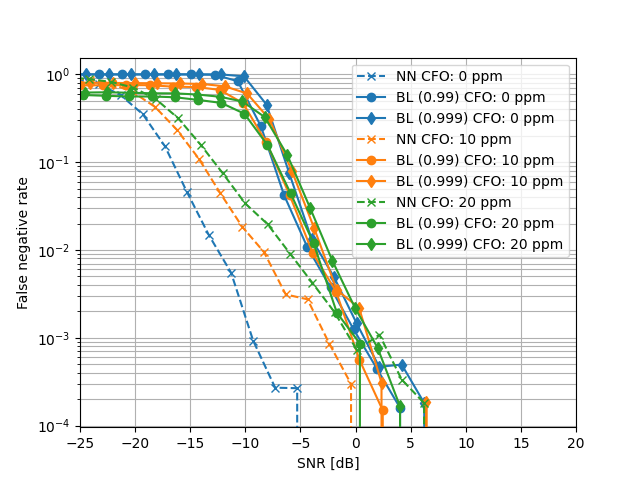

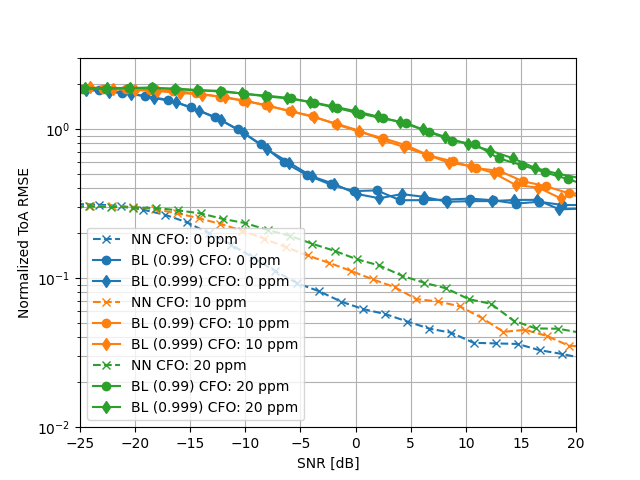

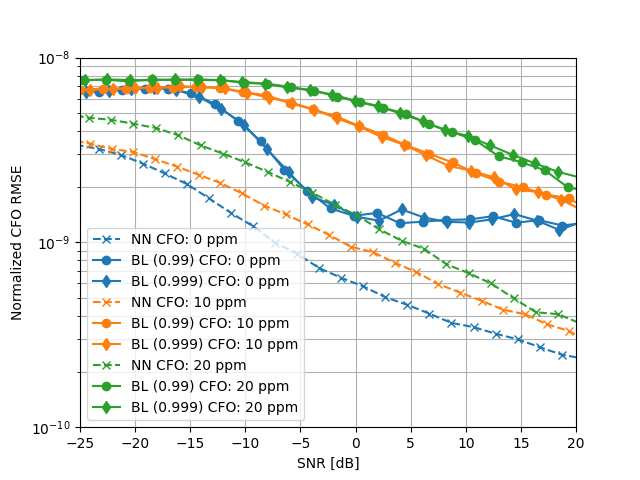

In [3]:
#############################################
# Loading the post-processed data
#############################################

with open("results/results_vs_snr.res", "rb") as f:
    DEEPNSYNCH_VS_SNR,BASELINE0_VS_SNR,BASELINE1_VS_SNR = pickle.load(f)
    
#############################################
# Plotting FNR vs SNR
#############################################
            
fig = plt.figure()
ax = fig.add_subplot()
ax.set_xlabel(r"SNR [dB]")
ax.set_ylabel(r"False negative rate")
ax.grid(which='both')
ax.set_xlim((-25,20))
for i,max_cfo_ppm in enumerate(EVAL_SNR_CFO_PPMs):
    # Deep learning
    ax.semilogy(DEEPNSYNCH_VS_SNR[max_cfo_ppm.numpy()][0], # SNR
                DEEPNSYNCH_VS_SNR[max_cfo_ppm.numpy()][1], # FNR
                ls='--', marker='x', color=f'C{i}',
                label=f'NN CFO: {max_cfo_ppm:.0f} ppm')
    # Baseline (0.99)
    ax.semilogy(BASELINE0_VS_SNR[max_cfo_ppm.numpy()][0], # SNR
                BASELINE0_VS_SNR[max_cfo_ppm.numpy()][1], # FNR
                ls='-', marker='o', color=f'C{i}',
                label=f'BL (0.99) CFO: {max_cfo_ppm:.0f} ppm')
    # Baseline (0.999)
    ax.semilogy(BASELINE1_VS_SNR[max_cfo_ppm.numpy()][0], # SNR
                BASELINE1_VS_SNR[max_cfo_ppm.numpy()][1], # FNR
                ls='-', marker='d', color=f'C{i}',
                label=f'BL (0.999) CFO: {max_cfo_ppm:.0f} ppm')
ax.legend()
        
#############################################
# Plotting ToA RMSE vs SNR
#############################################
            
fig = plt.figure()
ax = fig.add_subplot()
ax.set_xlabel(r"SNR [dB]")
ax.set_ylabel(r"Normalized ToA RMSE")
ax.grid(which='both')
ax.set_xlim((-25,20))
ax.set_ylim((1e-2, 3))
for i,max_cfo_ppm in enumerate(EVAL_SNR_CFO_PPMs):
    # Deep learning
    ax.semilogy(DEEPNSYNCH_VS_SNR[max_cfo_ppm.numpy()][0], # SNR
                DEEPNSYNCH_VS_SNR[max_cfo_ppm.numpy()][2], # ToA Est. Err
                ls='--', marker='x', color=f'C{i}',
                label=f'NN CFO: {max_cfo_ppm:.0f} ppm')
    # Baseline (0.99)
    ax.semilogy(BASELINE0_VS_SNR[max_cfo_ppm.numpy()][0], # SNR
                BASELINE0_VS_SNR[max_cfo_ppm.numpy()][2], # ToA Est. Err
                ls='-', marker='o', color=f'C{i}',
                label=f'BL (0.99) CFO: {max_cfo_ppm:.0f} ppm')
    # Baseline (0.999)
    ax.semilogy(BASELINE1_VS_SNR[max_cfo_ppm.numpy()][0], # SNR
                BASELINE1_VS_SNR[max_cfo_ppm.numpy()][2], # ToA Est. Err
                ls='-', marker='d', color=f'C{i}',
                label=f'BL (0.999) CFO: {max_cfo_ppm:.0f} ppm')
ax.legend()

#############################################
# Plotting CFO RMSE vs SNR
#############################################
            
fig = plt.figure()
ax = fig.add_subplot()
ax.set_xlabel(r"SNR [dB]")
ax.set_ylabel(r"Normalized CFO RMSE")
ax.grid(which='both')
ax.set_xlim((-25,20))
ax.set_ylim((1e-10, 1e-8))
for i,max_cfo_ppm in enumerate(EVAL_SNR_CFO_PPMs):
    # Deep learning
    ax.semilogy(DEEPNSYNCH_VS_SNR[max_cfo_ppm.numpy()][0], # SNR
                DEEPNSYNCH_VS_SNR[max_cfo_ppm.numpy()][3], # CFO Est. Err
                ls='--', marker='x', color=f'C{i}',
                label=f'NN CFO: {max_cfo_ppm:.0f} ppm')
    # Baseline (0.99)
    ax.semilogy(BASELINE0_VS_SNR[max_cfo_ppm.numpy()][0], # SNR
                BASELINE0_VS_SNR[max_cfo_ppm.numpy()][3], # CFO Est. Err
                ls='-', marker='o', color=f'C{i}',
                label=f'BL (0.99) CFO: {max_cfo_ppm:.0f} ppm')
    # Baseline (0.999)
    ax.semilogy(BASELINE1_VS_SNR[max_cfo_ppm.numpy()][0], # SNR
                BASELINE1_VS_SNR[max_cfo_ppm.numpy()][3], # CFO Est. Err
                ls='-', marker='d', color=f'C{i}',
                label=f'BL (0.999) CFO: {max_cfo_ppm:.0f} ppm')
ax.legend()

## vs CFO

### Utility functions for generating the results data and processing them

In [ ]:
@tf.function(jit_compile=True)
def sample_sys_cfo(sys, max_cfo_ppm):
    """
    Generates ``BATCH_SIZE_EVAL * NUM_IT_EVAL`` samples of
    false positive rate (FPR) by  looping ``NUM_IT_EVAL`` times over
    calls of ``sys()``.
    
    Each call samples a batch of size ``BATCH_SIZE_EVAL`` of 3GPP UMi
    channel realizations, CFOs, ToAs, and numbers of transmitting users,
    apply the channel time convolution with CFO and ToA on the preambles,
    and calls the synchronization method to predict the transmitting
    UEs.
    
    Input
    ------
    sys : Instance of E2E
        End-to-end system to sample.
    
    max_cfo_ppm : int
        Maximum CFO in ppm.
        
    Output
    -------   
    fnr : [NUM_IT_EVAL*BATCH_SIZE_EVAL*NPRACH_NUM_SC], tf.float
        False positives. Set to 1 if there is a false positive,
        0 if there is not, and -1 if not applicable, i.e., the user
        did not transmit.
    """
    fpr = tf.zeros(())
    for i in tf.range(NUM_IT_EVAL):
        _, _, _, _, fpr_, _, _, _ = sys(BATCH_SIZE_EVAL, max_cfo_ppm=max_cfo_ppm, ue_prob=DEFAULT_UE_PROB_EVAL)
        #
        fpr_ = tf.reshape(fpr_, [-1])
        fpr_ = tf.gather(fpr_, tf.where(fpr_ >= 0.0))
        fpr += tf.reduce_mean(fpr_)
    fpr /= tf.cast(NUM_IT_EVAL, tf.float32)
    return fpr

def eval_cfo(sys):
    """
    Loop over the CFO values from ``CFO_PPM_EVAL_RANGE`` and compute corresponding
    false positive rates (FPRs).
    
    Input
    ------
    sys : Instance of E2E
        End-to-end system to sample.
    
    Output
    -------
    FPR : [len(CFO_PPM_EVAL_RANGE)], tf.float
        False postiive rates.
    """
    FPR = []
    for max_cfo_ppm in CFO_PPM_EVAL_RANGE:
        fpr = sample_sys_cfo(sys, max_cfo_ppm)
        FPR.append(fpr.numpy())
    return FPR

### Generating results data, post-processing, and storing

In [ ]:
DEEPNSYNCH_VS_CFO = None
BASELINE0_VS_CFO = None
BASELINE1_VS_CFO = None

# Deep learning
print("Evaluating DeepNSynch")
sys = E2E('dl', False, nprach_num_rep=NPRACH_NUM_REP, nprach_num_sc=NPRACH_NUM_SC)
sys(1, 50., 0.5)
with open(DEEPNSYNCH_WEIGHTS, 'rb') as f:
    weights = pickle.load(f)
sys.set_weights(weights)
DEEPNSYNCH_VS_CFO = eval_cfo(sys)

# Baseline (0.99)
print("Evaluating baseline (0.99)")
sys = E2E('baseline', False, nprach_num_rep=NPRACH_NUM_REP, nprach_num_sc=NPRACH_NUM_SC, pfa=0.99)
BASELINE0_VS_CFO = eval_cfo(sys)

# Baseline (0.999)
print("Evaluating baseline (0.999)")
sys = E2E('baseline', False, nprach_num_rep=NPRACH_NUM_REP, nprach_num_sc=NPRACH_NUM_SC, pfa=0.999)
BASELINE1_VS_CFO = eval_cfo(sys)

with open("results/results_vs_cfo.res", "wb") as f:
    pickle.dump((DEEPNSYNCH_VS_CFO,BASELINE0_VS_CFO,BASELINE1_VS_CFO),f)

### Plotting

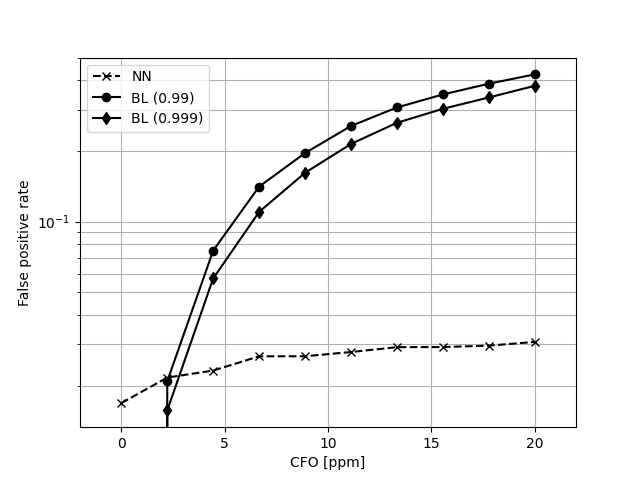

In [4]:
with open("results/results_vs_cfo.res", "rb") as f:
    DEEPNSYNCH_VS_CFO,BASELINE0_VS_CFO,BASELINE1_VS_CFO = pickle.load(f)
            
fig = plt.figure()
ax = fig.add_subplot()
ax.set_xlabel(r"CFO [ppm]")
ax.set_ylabel(r"False positive rate")
ax.grid(which='both')
ax.set_xlim((-2,22))
# Deep learning
ax.semilogy(CFO_PPM_EVAL_RANGE, # CFO
            DEEPNSYNCH_VS_CFO, # FPR
            ls='--', marker='x', color='k',
            label='NN')
# Baseline (0.99)
ax.semilogy(CFO_PPM_EVAL_RANGE, # CFO
            BASELINE0_VS_CFO, # FPR
            ls='-', marker='o', color='k',
            label='BL (0.99)')
# Baseline (0.999)
ax.semilogy(CFO_PPM_EVAL_RANGE, # CFO
            BASELINE1_VS_CFO, # FPR
            ls='-', marker='d', color='k',
            label='BL (0.999)')
ax.legend()

## VS Ptx

### Utility functions for generating the results data and processing them

In [ ]:
@tf.function(jit_compile=True)
def sample_sys_ptx(sys, ptx, max_cfo_ppm):
    """
    Generates ``BATCH_SIZE_EVAL * NUM_IT_EVAL`` samples of SNRs,
    ToA estimation error and CFO estimation error for every
    preambles by looping ``NUM_IT_EVAL`` times over calls of ``sys()``.
    
    Each call samples a batch of size ``BATCH_SIZE_EVAL`` of 3GPP UMi
    channel realizations, CFOs, ToAs, and numbers of transmitting users,
    apply the channel time convolution with CFO and ToA on the preambles,
    and calls the synchronization method to predict the transmitting
    UEs, CFO, and ToAs.
    
    Input
    ------
    sys : Instance of E2@
        End-to-end system to sample.
    
    max_cfo_ppm : int
        Maximum CFO in ppm.
        
    Output
    -------    
    toa_err : [NUM_IT_EVAL*BATCH_SIZE_EVAL*NPRACH_NUM_SC], tf.float
        Time-of-arrival estimation error normalized by the cyclic prefix
        duration. Set to 0 for inactive users.
    
    cfo_err : [NUM_IT_EVAL*BATCH_SIZE_EVAL*NPRACH_NUM_SC], tf.float
        CFO estimation error normalized by the bandwidth.
        Set to 0 for inactive users.
    """

    toa_err = tf.zeros(())
    cfo_err = tf.zeros(())
    for i in tf.range(NUM_IT_EVAL):
        _, _, _, _, _, _, toa_err_, cfo_err_ = sys(BATCH_SIZE_EVAL, max_cfo_ppm=max_cfo_ppm, ue_prob=ptx)
        #
        toa_err_ = tf.reshape(toa_err_, [-1])
        cfo_err_ = tf.reshape(cfo_err_, [-1])
        toa_err_ = tf.reduce_mean(toa_err_)
        cfo_err_ = tf.reduce_mean(cfo_err_)
        #
        toa_err += toa_err_
        cfo_err += cfo_err_
    toa_err /= tf.cast(NUM_IT_EVAL, tf.float32)
    cfo_err /= tf.cast(NUM_IT_EVAL, tf.float32)
    return toa_err, cfo_err

def eval_ptx(sys, max_cfo_ppm):
    """
    Loop over the probability of transmission values from ``PTX_EVAL_RANGE``
    and compute ToA and CFO estimation errors.
    
    Input
    ------
    sys : Instance of E2E
        End-to-end system to sample.
    
    max_cfo_ppm : int
        Maximum CFO [ppm].
    
    Output
    -------
    TOA_ERR : [len(PTX_EVAL_RANGE)], tf.float
        Time-of-arrival estimation errors.
    
    CFO_ERR : [len(PTX_EVAL_RANGE)], tf.float
        Carrier frequency offset estimation errors.
    """

    TOA_ERR = []
    CFO_ERR = []
    for ptx in PTX_EVAL_RANGE:
        toa_err, cfo_err = sample_sys_ptx(sys, ptx, max_cfo_ppm)
        TOA_ERR.append(np.sqrt(toa_err.numpy()))
        CFO_ERR.append(np.sqrt(cfo_err.numpy()))
    return TOA_ERR, CFO_ERR

In [ ]:
DEEPNSYNCH_VS_PTX = {}
BASELINE0_VS_PTX = {}
BASELINE1_VS_PTX = {}

for i,max_cfo_ppm in enumerate(EVAL_SNR_CFO_PPMs):
    # DL
    print(f"Evaluating DeepNSynch with max CFO [ppm]: {max_cfo_ppm:.1f}")
    sys = E2E('dl', False, nprach_num_rep=NPRACH_NUM_REP, nprach_num_sc=NPRACH_NUM_SC)
    sys(1, 50., 0.5)
    with open(DEEPNSYNCH_WEIGHTS, 'rb') as f:
        weights = pickle.load(f)
    sys.set_weights(weights)
    DEEPNSYNCH_VS_PTX[max_cfo_ppm.numpy()] = eval_ptx(sys, max_cfo_ppm)

    # Baseline 0
    print(f"Evaluating baseline (0.99) with max CFO [ppm]: {max_cfo_ppm:.1f}")
    sys = E2E('baseline', False, nprach_num_rep=NPRACH_NUM_REP, nprach_num_sc=NPRACH_NUM_SC, pfa=0.99)
    BASELINE0_VS_PTX[max_cfo_ppm.numpy()] = eval_ptx(sys, max_cfo_ppm)
    
    # Baseline 1
    print(f"Evaluating baseline (0.999) with max CFO [ppm]: {max_cfo_ppm:.1f}")
    sys = E2E('baseline', False, nprach_num_rep=NPRACH_NUM_REP, nprach_num_sc=NPRACH_NUM_SC, pfa=0.999)
    BASELINE1_VS_PTX[max_cfo_ppm.numpy()] = eval_ptx(sys, max_cfo_ppm)

with open("results/results_vs_ptx.res", "wb") as f:
    pickle.dump((DEEPNSYNCH_VS_PTX,BASELINE0_VS_PTX,BASELINE1_VS_PTX),f)

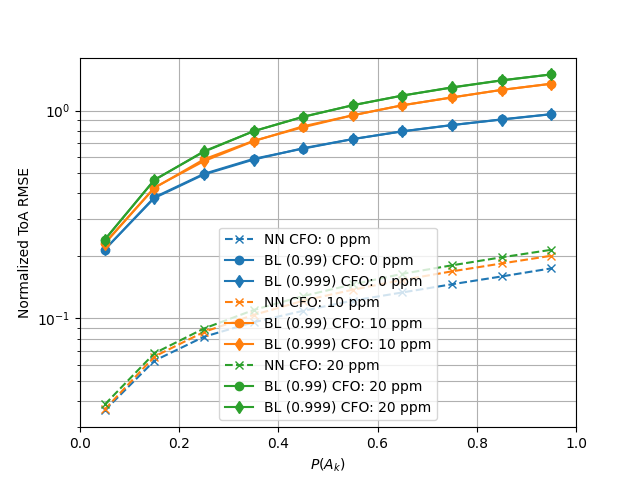

In [5]:
with open("results/results_vs_ptx.res", "rb") as f:
    DEEPNSYNCH_VS_PTX,BASELINE0_VS_PTX,BASELINE1_VS_PTX = pickle.load(f)
    
        
fig = plt.figure()
ax = fig.add_subplot()
ax.set_xlabel(r"$P(A_k)$")
ax.set_ylabel(r"Normalized ToA RMSE")
ax.grid(which='both')
ax.set_xlim((0.0,1.0))
for i,max_cfo_ppm in enumerate(EVAL_SNR_CFO_PPMs):
    # Deep learning
    ax.semilogy(PTX_EVAL_RANGE, # Prob. TX
                DEEPNSYNCH_VS_PTX[max_cfo_ppm.numpy()][0], # ToA Est. Err.
                ls='--', marker='x', color=f'C{i}',
                label=f'NN CFO: {max_cfo_ppm:.0f} ppm')
    # Baseline (0.99)
    ax.semilogy(PTX_EVAL_RANGE, # Prob. TX
                BASELINE0_VS_PTX[max_cfo_ppm.numpy()][0], # FNR
                ls='-', marker='o', color=f'C{i}', # ToA Est. Err.
                label=f'BL (0.99) CFO: {max_cfo_ppm:.0f} ppm')
    # Baseline (0.999)
    ax.semilogy(PTX_EVAL_RANGE, # Prob. TX
                BASELINE1_VS_PTX[max_cfo_ppm.numpy()][0], # FNR
                ls='-', marker='d', color=f'C{i}', # ToA Est. Err.
                label=f'BL (0.999) CFO: {max_cfo_ppm:.0f} ppm')
ax.legend()